In [10]:
'''
This code reads all the moments from FLASK simulations;
it performs the noise subtraction (FLASK moments haven0t been de-noised)
and if needed add the 'modelling uncertainties'. Then it saves a list of corrected
FLASK moments objects - this is what is needed to run the analysis.

'''

'''
de-noise.
Based on FLASK:
only auto-moments for <dd> ans <ddd>.
<dd> : <nn> needs to be subtracted, <nd>  2order smaller
<ddd> : <nnn> needs to be subtracted, <ndd>, <nnd>  2order smaller

<dK> : need to subtract <dKN> , others zero.
<dKK>: need to subtract everything, dkNkN dominant
<KKd>: need to subtract everything
'''

import copy
import os
import pickle
from Moments_analysis import moments_map, make_covariance

def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)#, encoding='latin1')
    
output_FLASK = '/global/cscratch1/sd/mgatti/Mass_Mapping/moments/flask_tests/'
N_rel = 100


In [11]:
mapp = []
bins_lenses = [0]#, 1, 2, 3]
bins_WL = [0]#, 1, 2, 3]
# dict_keys(['kEkE', 'kBkB', 'kEkN', 'kNkN', 'kNkE', 'dKK', 'Kdd', 'dkNkN', 'nKK', 'nkNkN', 'kNdd', 'knn', 'kNnn', 'dd', 'nn', 'dnn', 'ndd'])
 
for i in range(N_rel):
    try:
        mute = load_obj(output_FLASK+'moments_seed_'+str(i+1))
        mapp.append(copy.deepcopy(mute))
        if i == 0 :
            mapp_ave = copy.copy(mute)
            for key in mapp_ave.moments.keys():
                for key2 in mapp_ave.moments[key].keys():
                    mapp_ave.moments[key][key2] = mapp_ave.moments[key][key2]/N_rel
            mapp_ave.PS = dict()
            for key in mute.PS.keys():
                mapp_ave.PS[key]  = mute.PS[key]/N_rel
                
        else:
            for key in mapp_ave.moments.keys():
                for key2 in mapp_ave.moments[key].keys():
                    mapp_ave.moments[key][key2] += mute.moments[key][key2]/N_rel

            for key in mapp_ave.PS.keys():
                mapp_ave.PS[key] += mute.PS[key]/N_rel
        #for key in mapp[i].moments.keys():
        #    for key2 in mapp[i].moments[key].keys():
        #        del mapp[i].moments[key][key2]
        #        mapp[i].moments[key][key2] = copy.deepcopy(mute.moments[key][key2])
                


        for b1 in bins_WL:
            # noise subtraction
            binx = '{0}_{0}'.format(b1)

            mapp[i].moments['kEkE'][binx] -= mapp[i-1].moments['kNkN'][binx]
            mapp[i].moments['kBkB'][binx] -= mapp[i-1].moments['kNkN'][binx]

        for b1 in bins_lenses:
            for b2 in bins_WL:
                binx = '{0}_{1}'.format(b1,b2)
                mapp[i].moments['dKK'][binx] -= mapp[i-1].moments['dkNkN'][binx]
                binx = '{0}_{1}'.format(b2,b1)
                mapp[i].moments['Kdd'][binx] -= mapp[i-1].moments['kNdd'][binx]


        for b1 in bins_lenses:
            for b2 in bins_lenses:
                for b3 in bins_lenses:
                    try:
                        binx = '{0}_{1}_{2}'.format(b1, b2, b3)
                        mapp[i].moments['ddd'][binx] -= (mapp[i-1].moments['nnn'][binx]+3*mapp[i-1].moments['ndd'][binx]+3*mapp[i-1].moments['dnn'][binx])
                    except:
                        pass
                    
        for b1 in bins_lenses:
            for b2 in bins_WL:
                for b3 in bins_WL:
                    try:
                        binx = '{0}_{1}_{2}'.format(b1, b2, b3)
                        mapp[i].moments['dKK'][binx] -= (mapp[i-1].moments['nkNkN'][binx]+3*mapp[i-1].moments['nKK'][binx]+3*mapp[i-1].moments['dkNkN'][binx])
                    except:
                        pass
                    
        for b1 in bins_WL:
            for b2 in bins_lenses:
                for b3 in bins_lenses:
                    try:
                        binx = '{0}_{1}_{2}'.format(b1, b2, b3)
                        mapp[i].moments['Kdd'][binx] -= (mapp[i-1].moments['kNnn'][binx]+3*mapp[i-1].moments['kNdd'][binx]+3*mapp[i-1].moments['knn'][binx])
                    except:   
                        pass
                    
        for b1 in bins_WL:
            for b2 in bins_WL:
                for b3 in bins_WL:
                    try:
                        binx = '{0}_{1}_{2}'.format(b1, b2, b3)
                        mapp[i].moments['kEkE'][binx] = copy.deepcopy(mapp[i].moments['kEkE'][binx]- 3*mapp[i-1].moments['kEkN'][binx])
                    except:
                        pass
    except:
        print ('failed ',i)
        mapp.append(mapp[i-1])
        for key in mapp_ave.moments.keys():
            for key2 in mapp_ave.moments[key].keys():
                mapp_ave.moments[key][key2] += mapp[i-1].moments[key][key2]/N_rel
save_obj('/global/project/projectdirs/des/mgatti/Moments_analysis/Cov_FLASK_Y3',mapp)
save_obj('/global/project/projectdirs/des/mgatti/Moments_analysis/Ave_FLASK_Y3',mapp_ave)

print ('done')

done


In [88]:
import numpy as np
var = []
for i in range(500):
    binx = '2_2'
    var.append(mapp[i].moments['kEkE'][binx])#- 3*mapp[i-1].moments['kEkN'][binx])
np.mean(np.array(var),axis=0)

array([7.02358021e-06, 5.44489787e-06, 3.77896598e-06, 2.58281594e-06,
       1.73403392e-06, 1.14380607e-06, 7.25554232e-07, 4.39699892e-07,
       2.44961057e-07, 1.25025272e-07])

array([[ 1.        ,  0.92522275,  0.69075623, ..., -0.06902691,
        -0.0308859 , -0.02788409],
       [ 0.92522275,  1.        ,  0.88507852, ..., -0.08195102,
        -0.03407335, -0.04741721],
       [ 0.69075623,  0.88507852,  1.        , ..., -0.07882119,
        -0.02915659, -0.05186828],
       ...,
       [-0.06902691, -0.08195102, -0.07882119, ...,  1.        ,
         0.81487883,  0.56695496],
       [-0.0308859 , -0.03407335, -0.02915659, ...,  0.81487883,
         1.        ,  0.82041583],
       [-0.02788409, -0.04741721, -0.05186828, ...,  0.56695496,
         0.82041583,  1.        ]])

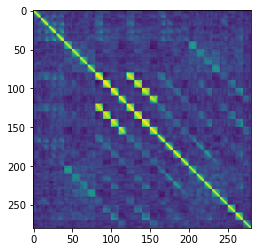

In [2]:
path_cov = "/global/project/projectdirs/des/mgatti/Moments_analysis/Cov_FLASK_Y3"
map_flask_reals = load_obj(path_cov)

bins_dictionary = dict()
bins_dictionary['auto'] = dict()
bins_dictionary['auto']['kEkE'] = {'bins':[[1,1],[2,2],[3,3],[4,4],[1,1,1],[2,2,2],[3,3,3],[4,4,4]], 'scale_cut': None, 'Nz_mean': None}
bins_dictionary['auto']['dd'] = {'bins':[[1,1],[2,2],[3,3],[4,4],[1,1,1],[2,2,2],[3,3,3],[4,4,4]], 'scale_cut': None, 'Nz_mean': None}
bins_dictionary['auto']['Kdd'] = {'bins':[[1,1],[2,2],[3,3],[4,4], [1,1,1],[2,2,2],[3,3,3],[4,4,4]],'scale_cut': None, 'Nz_mean': None}
bins_dictionary['auto']['dKK'] = {'bins':[[1,1,1],[2,2,2],[3,3,3],[4,4,4]],'scale_cut': None, 'Nz_mean': None}


import numpy as np
smoothing_scales = np.array([3.2,5.1,8.2,13.1,21.0,33.6,54.,86.,138,221.])

numb_of_real = 500
cov2a,v2,err2 = make_covariance(map_flask_reals, numb_of_real, smoothing_scales, bins_dictionary['auto'])

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(cov2a['corr'])
cov2a['corr']

In [125]:
def make_covariance(mapp, num_real, scales, bins_dictionary):
    '''
    This routine create a covariance matrix from a list of FLASK moments.
    mapp: list of flask moments.
    num_real: number of realisations
    scales: smoothing scales
    bins_dictionary: it informs the code about the correlation and scales that needs to be included.
    
    
    '''
    
    # fiducial cosmology for the scale cut conversion.
    cosmo = {'omega_M_0':0.3,
             'omega_lambda_0':1-0.3,
              'omega_k_0': 0.0,
              'omega_b_0' : 0.047,
               'h':0.7,
               'sigma_8' : 0.82}
    
    import numpy as np
    
    # setup bins ************************************
    bins = []
    len_v = 0
    
    # this bit appends the bins and apply scale cut if needed
    for key in bins_dictionary.keys():
        for bi in bins_dictionary[key]['bins']:
            bins.append(bi)

            try:
                # scale cut ***
                zzm=0.
                min_theta_rp=0.
                if bins_dictionary[key]['scale_cut'] == 'physical':
                    # we take the mean of the <z> of the tomographic bins involved. We use this redshift
                    # to convert a cut from physical scales to angular scales.
                    for bx in bi:
                        zzm += Nz_mean[bx-1]
                    min_theta_rp=(physical_scale_cut[0]/((1.+zzm/len(bi))*cd.comoving_distance(zzm/len(bi),**cosmo)*(2*math.pi)/360)*60)
                    mask_scales = (np.array(scales)>min_theta_rp) 
                    len_v+= len(np.array(scales[mask_scales]))
                else:
                    len_v += len(np.array(scales))
                    
            except:
                len_v += len(np.array(scales))
    
    # now we can initialise the vector holding the moments from different FLASK simulations.
    vector = np.zeros((num_real,len_v))
    for jk in range(num_real):
        count=0
        for key in bins_dictionary.keys():
            for bi in bins_dictionary[key]['bins']:
                # binx: label of the bins in the format from FLASK
                binx = '_'.join([str(l-1) for l in bi])


                mask_scales = scales == scales
                try:
                    # scale cut ***
                    zzm=0.
                    min_theta_rp=0.
                    if bins_dictionary[key]['scale_cut'] == 'physical':
                        # we take the mean of the <z> of the tomographic bins involved. We use this redshift
                        # to convert a cut from physical scales to angular scales.
                        for bx in bi:
                            zzm += Nz_mean[bx-1]
                        min_theta_rp=(physical_scale_cut[0]/((1.+zzm/len(bi))*cd.comoving_distance(zzm/len(bi),**cosmo)*(2*math.pi)/360)*60)
                        mask_scales =np.array(scales)>min_theta_rp   
                        
                except:
                    pass
                mask = np.in1d(mapp[0].conf['smoothing_scales'],np.array(scales)[mask_scales])
                lent = len(mapp[0].conf['smoothing_scales'][mask])
                vector[jk,count:(count+lent)] = mapp[jk].moments[key][binx][mask]
                count+=lent
                
    cov_dict = covariance_jck(vector.T,num_real,"bootstrap")
    
    # the routine also gives back a dictionary with the diagonal elements of the covariance divided per bin combinations.
    err_dict_plot = dict()
    count = 0
    for key in bins_dictionary.keys():
        for bi in bins_dictionary[key]['bins']:
            # binx: label of the bins in the format from FLASK
            binx = '_'.join([str(l-1) for l in bi])
            mask_scales = scales == scales
            try:
                # scale cut ***
                zzm=0.
                min_theta_rp=0.
                if bins_dictionary[key]['scale_cut'] == 'physical':
                    # we take the mean of the <z> of the tomographic bins involved. We use this redshift
                    # to convert a cut from physical scales to angular scales.
                    for bx in bi:
                        zzm += Nz_mean[bx-1]
                    min_theta_rp=(physical_scale_cut[0]/((1.+zzm/len(bi))*cd.comoving_distance(zzm/len(bi),**cosmo)*(2*math.pi)/360)*60)
                    mask_scales =np.array(scales)>min_theta_rp
            except:
                pass
            mask = np.in1d(mapp[0].conf['smoothing_scales'],np.array(scales)[mask_scales])
            lent = len(mapp[0].conf['smoothing_scales'][mask])
            err_dict_plot[key+'_'+binx] = cov_dict['err'][count:(count+lent)]
            count +=lent
    return cov_dict,vector,err_dict_plot


dict_keys(['kEkE_0_0', 'kEkE_1_1', 'kEkE_2_2', 'kEkE_3_3', 'kEkE_0_0_0', 'kEkE_1_1_1', 'kEkE_2_2_2', 'kEkE_3_3_3', 'dd_0_0', 'dd_1_1', 'dd_2_2', 'dd_3_3', 'dd_0_0_0', 'dd_1_1_1', 'dd_2_2_2', 'dd_3_3_3', 'Kdd_0_0', 'Kdd_1_1', 'Kdd_2_2', 'Kdd_3_3', 'Kdd_0_0_0', 'Kdd_1_1_1', 'Kdd_2_2_2', 'Kdd_3_3_3', 'dKK_0_0_0', 'dKK_1_1_1', 'dKK_2_2_2', 'dKK_3_3_3'])

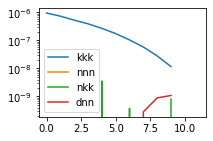

In [95]:
'''
<dK> : neglgible <dKN> , others zero.
<dKK>: need to subtract everything, dkNkN dominant

'''

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
binx = '3_1'

fig, ax = plt.subplots(1,1, figsize=(3,2), sharey = 'row')

ax.plot(mapp_ave.moments['dKK'][binx], label = 'kkk')
ax.plot(mapp_ave.moments['nkNkN'][binx], label = 'nnn')
ax.plot(mapp_ave.moments['nKK'][binx], label = 'nkk')
ax.plot(mapp_ave.moments['dkNkN'][binx], label = 'dnn')
ax.plot(np.arange(12),np.zeros(12),color='black')
ax.set_yscale('log')
plt.legend()

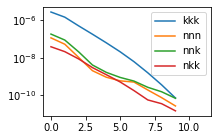

In [99]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
binx = '3_3_3'

fig, ax = plt.subplots(1,1, figsize=(3,2), sharey = 'row')

ax.plot(mapp_ave.moments['Kdd'][binx], label = 'kkk')
ax.plot(mapp_ave.moments['kNnn'][binx], label = 'nnn')
ax.plot(mapp_ave.moments['knn'][binx], label = 'nnk')
ax.plot(mapp_ave.moments['kNdd'][binx], label = 'nkk')
ax.plot(np.arange(12),np.zeros(12),color='black')
ax.set_yscale('log')
plt.legend()

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


'\nde-noise.\nBased on FLASK:\nonly auto-moments for <dd> ans <ddd>.\n<dd> : <nn> needs to be subtracted, <nd>  2order smaller\n<ddd> : <nnn> needs to be subtracted, <ndd>, <nnd>  2order smaller\n\n'

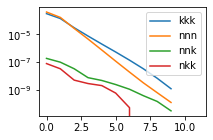

In [126]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
binx = '3_3_3'
fig, ax = plt.subplots(1,1, figsize=(3,2), sharey = 'row')


ax.plot(mapp_ave.moments['dd'][binx], label = 'kkk')
ax.plot(mapp_ave.moments['nn'][binx], label = 'nnn')
ax.plot(-mapp_ave.moments['dnn'][binx], label = 'nnk')
ax.plot(mapp_ave.moments['ndd'][binx], label = 'nkk')
ax.plot(np.arange(12),np.zeros(12),color='black')
ax.set_yscale('log')
plt.legend()

'''
de-noise.
Based on FLASK:
only auto-moments for <dd> ans <ddd>.
<dd> : <nn> needs to be subtracted, <nd>  2order smaller
<ddd> : <nnn> needs to be subtracted, <ndd>, <nnd>  2order smaller

'''

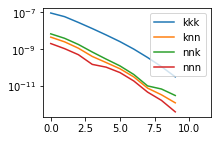

In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
binx = '3_3_3'
fig, ax = plt.subplots(1,1, figsize=(3,2), sharey = 'row')

ax.plot(mapp_ave.moments['kEkE'][binx], label = 'kkk')
ax.plot(mapp_ave.moments['kEkN'][binx], label = 'knn')
ax.plot(mapp_ave.moments['kNkE'][binx], label = 'nnk')
ax.plot(mapp_ave.moments['kNkN'][binx], label = 'nnn')
ax.plot(np.arange(12),np.zeros(12),color='black')
ax.set_yscale('log')
plt.legend()